In [95]:
# basic
import numpy as np
import pandas as pd
from IPython.display import display
import sys
import os
sys.path.append('../../utils')

In [96]:
# visualization
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

In [97]:
# utils libs
from process import *

In [98]:
## Creating an object
%time ip = ImagePrec(path = '../../data/train',size=128, channel=3, normalize=True, augment=True)


## Generating training batch for the training process
%time train = ip.get_batch_data(expand=4, seed=17)
%time print train['x'].shape
%time print train['y'].shape

Extracting training image info ...
Time Usage: 51.246792078 sec
5360 5360 5360
CPU times: user 46.6 s, sys: 5.12 s, total: 51.8 s
Wall time: 51.3 s
Getting cropped images ...
Time Usage: 0.141420841217 sec
CPU times: user 2.23 s, sys: 1.34 s, total: 3.57 s
Wall time: 3.52 s
(21440, 128, 128, 3)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 351 µs
(21440, 128, 128)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 256 µs


In [99]:
idx = np.array([np.random.randint(len(train['x'])) for i in range(9)])
print idx

[ 8631 18766  1926 14956 19941 18334 19091 19231 17744]


In [100]:
imgs = train['x'][idx]
masks = train['y'][idx]

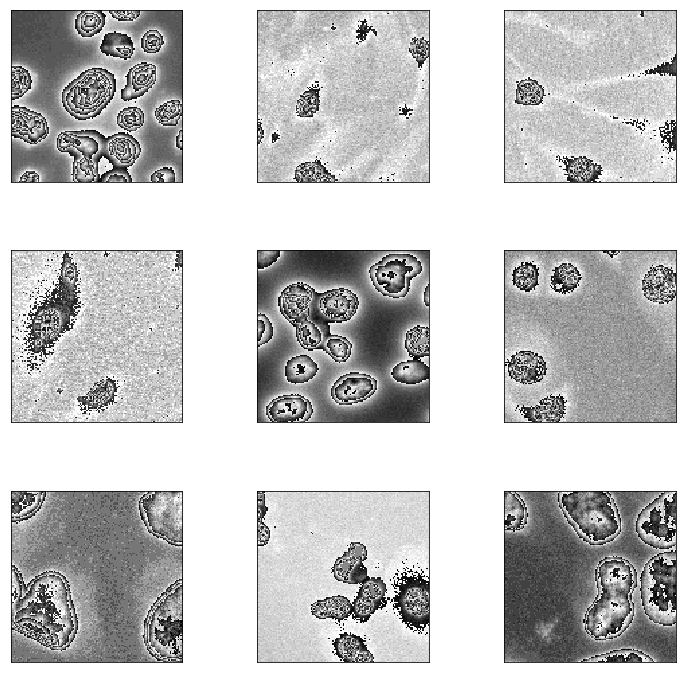

In [101]:
fig, axes = plt.subplots(3, 3, figsize = (12, 12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i])
    ax.set_xticks([])
    ax.set_yticks([])

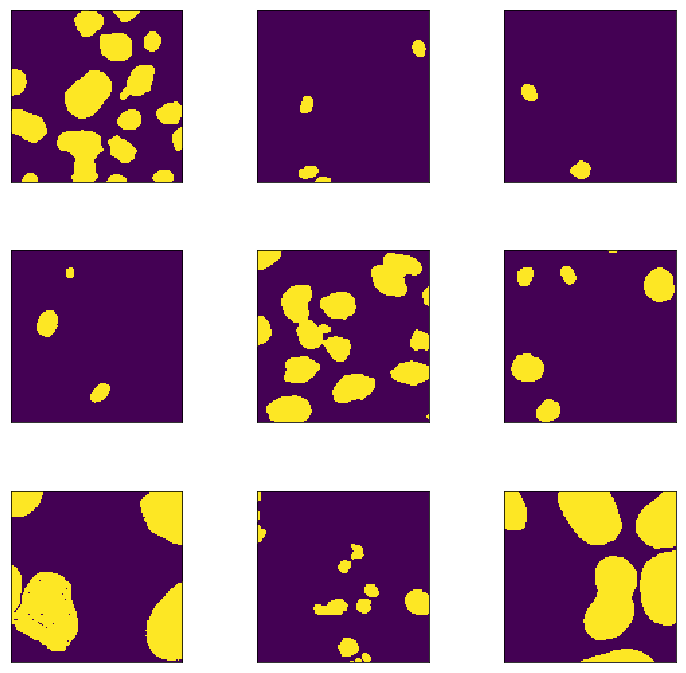

In [102]:
fig, axes = plt.subplots(3, 3, figsize = (12, 12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i, ax in enumerate(axes.flat):
    ax.imshow(masks[i])
    ax.set_xticks([])
    ax.set_yticks([])

In [103]:
print len(ip._imgs)
idx = np.array([np.random.randint(len(ip._imgs)) for i in range(9)])
imgs = [ip._imgs[i] for i in idx]
masks = [ip._masks[i] for i in idx]

5360


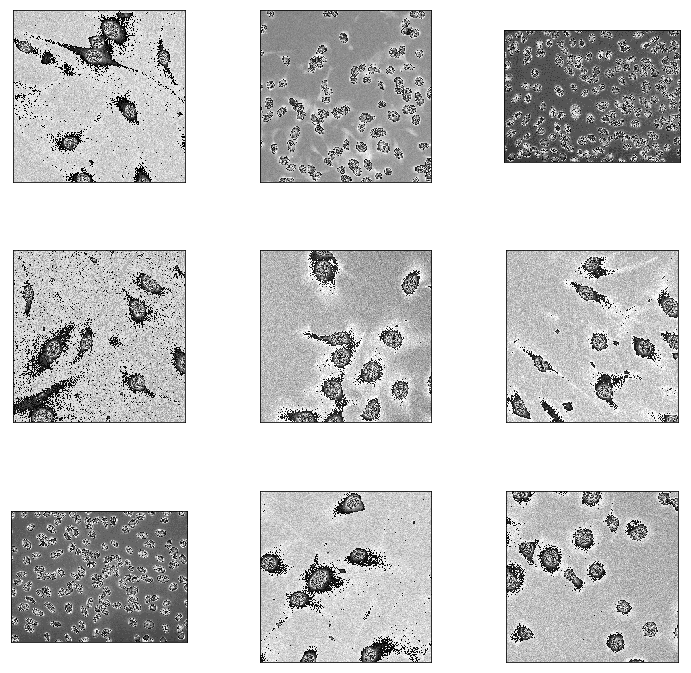

In [104]:
fig, axes = plt.subplots(3, 3, figsize = (12, 12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i])
    ax.set_xticks([])
    ax.set_yticks([])

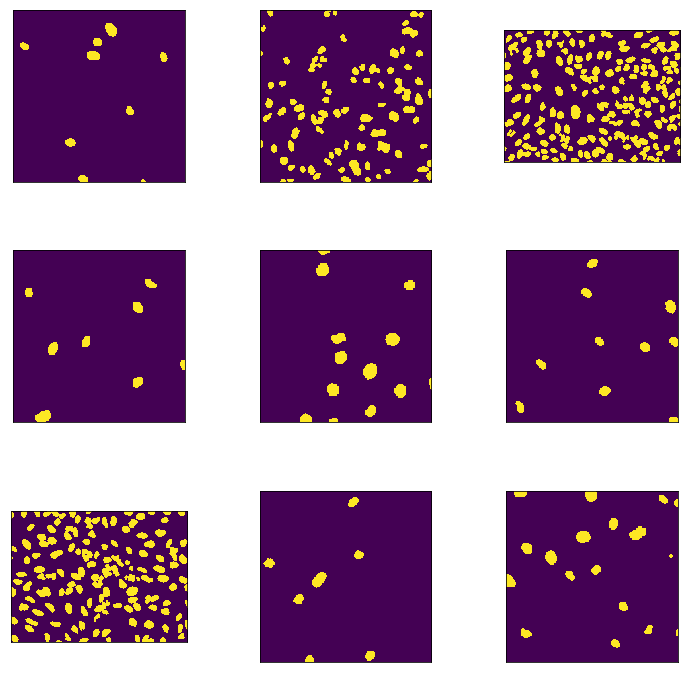

In [105]:
fig, axes = plt.subplots(3, 3, figsize = (12, 12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i, ax in enumerate(axes.flat):
    ax.imshow(masks[i])
    ax.set_xticks([])
    ax.set_yticks([])

In [114]:
# Keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Input, Reshape
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from keras.utils import np_utils, plot_model
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import LearningRateScheduler
from keras import regularizers
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

In [115]:
model = Sequential()
model.add(Conv2D(8, input_shape = (128, 128, 3), kernel_size = (7, 7), padding = 'same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv2D(16, kernel_size = (5, 5), padding = 'same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size = (5, 5), padding = 'same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Conv2D(1, kernel_size = (3, 3), padding = 'same'))
model.add(Activation('sigmoid'))
model.add(Reshape((128, 128)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 128, 128, 8)       1184      
_________________________________________________________________
activation_80 (Activation)   (None, 128, 128, 8)       0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 128, 128, 16)      3216      
_________________________________________________________________
activation_81 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 128, 128, 32)      12832     
__________

In [ ]:
learning_rate = 0.01
optimizer = SGD(learning_rate)
loss = 'binary_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
for i in range(6):
    %time train = ip.get_batch_data(expand=8, seed=i**2)
    model.fit(train['x'], train['y'], batch_size=32, epochs=2, verbose=1)

Getting cropped images ...
Time Usage: 0.703412055969 sec
